In [1]:
import pandas as pd
import numpy as np
from scipy.signal import find_peaks
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt

In [2]:
def remove_duplicates(x: list[float], y: list[float]):
    duplicates = []
    for i in range(1, len(x)-1):
        if x[i] == x[i-1]:
            duplicates.append(i)
        
    for i in duplicates[::-1]:
        x.pop(i)
        y.pop(i)
    return x, y

In [ ]:
def smouthener(x: list, y: list, r: int):
    sm_x = []
    sm_y = []
    i = r
    while i <= len(x)-r-1:
        av_x = 0
        av_y = 0
        for j in range(0, r):
            av_x += x[i-j]
            av_y += y[i-j]
        av_x /= r
        av_y /=r
        i += r

        sm_x.append(av_x)
        sm_y.append(av_y)
    return sm_x, sm_y

In [ ]:
def calculate_base_line(y: list[float], n_sigma: int):
    b_l = (sum(y)) / len(y)
    b_l_disp = sum([((i-b_l)**2)/len(y) for i in y])
    b_l_sigma = b_l_disp**0.5
    b_l_delta = n_sigma * b_l_sigma
    return b_l, b_l_delta

In [3]:
def plot_base_line(x, b_l: float, b_l_delta: float, dim: int):
    b_l_list = [b_l for i in range(0, dim)]
    b_l_plus_delta = [b_l + b_l_delta for i in range(dim)]
    b_l_minus_delta = [b_l - b_l_delta for i in range(dim)]

    plt.plot(x, b_l_list, color="green")
    plt.plot(x, b_l_plus_delta, "--", color="green")
    plt.plot(x, b_l_minus_delta, "--", color="green")

In [6]:
def calculate_left_border(x: list[float], y: list[float], b_l: float, b_l_delta: float, peak: int, end1: int, r: int):
    i = peak
    while i <= end1:
        check_list = []
        if y[i] <= b_l + b_l_delta and y[i] >= b_l - b_l_delta:
            for j in range(1, r+1):
                 if y[i+j] <= b_l + b_l_delta and y[i+j] >= b_l - b_l_delta:
                    check_list.append(True)
                 else:
                    check_list.append(False)
            if all(check_list): 
                return x[i], y[i]
        i += 1
    return x[end1], y[end1]

In [7]:
def calculate_right_border(x: list[float], y: list[float], b_l: float, b_l_delta: float, peak: int, end2: int, r: int):
    i = peak
    while i >= r:
        check_list = []
        if y[i] <= b_l + b_l_delta and y[i] >= b_l - b_l_delta:
            for j in range(1, r+1):
                if y[i-j] <= b_l + b_l_delta:
                    check_list.append(True)
                else:
                    check_list.append(False)
            if all(check_list): 
                return x[i], y[i]
        i -= 1
    return x[0], y[0]

In [8]:
def calculate_recession(b_l: float, b_l_delta: float, y: list[float], r):
    b_l_min = b_l - b_l_delta
    for i in range(len(y)-1 - r, r, -1):
        check_list = []
        if y[i] < b_l_min and y[i-1] >= b_l_min:
            for j in range(1, r + 1):
                if y[i+j] < b_l_min and y[i-1-j] >= b_l_min:
                    check_list.append(True)
                else:
                    check_list.append(False)
            if all(check_list):
                return i - 1 # возвращаем точку, ещё лежащую в интервале

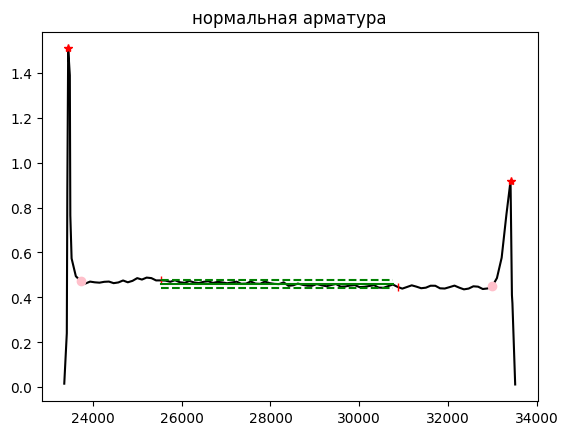

In [29]:
df = pd.read_csv("/home/marat/repo/jupyter_data/dataset/norm.csv", sep ="|")
x, y = remove_duplicates(list(df.iloc[:, 0]), list(df.iloc[:, 1]))
#plt.plot(x, y, color="pink")
x, y = smouthener(x, y, 5)
plt.plot(x, y, color="black")
plt.title("нормальная арматура")

end1 = len(x) // 4
end2 = end1 * 3


# расчитываем границы первоначальных областей поиска
border_left = (x[end1], y[end1])
border_right = (x[end2], y[end2])

plt.plot(border_left[0], border_left[1], "|", color="red")
plt.plot(border_right[0], border_right[1], "|", color="red")


# расчитываем максимумы в зонах 1 и 3
x_beg = x[:end1]
y_beg = y[:end1]
max_heigh_beg = max(y_beg)

x_end = x[end2:]
y_end = y[end2:]
max_heigh_end = max(y_end)


# расчитываем характеристики распределения в зоне 2
x_mid = x[end1:end2]
y_mid = y[end1:end2]
b_l, b_l_delta = calculate_base_line(y_mid, 2)
plot_base_line(x_mid, b_l, b_l_delta, len(x_mid))


# находим пики в зонах 1 и 3
peaks_beg, _ = find_peaks(y_beg, height=0.9*max_heigh_beg)
peaks_end, _ = find_peaks(y_end, height=0.9*max_heigh_end)

for elm in peaks_beg:
    plt.plot(x_beg[elm], y_beg[elm], "*", color="red")
for elm in peaks_end:
    plt.plot(x_end[elm], y_end[elm], "*", color="red")


# расчитываем новые границы (по пикам и базовой линии зоны 2)
new_border_left = calculate_left_border(x, y, b_l, b_l_delta, peaks_beg[-1], end1, 5)
new_border_right = calculate_right_border(x_end, y_end, b_l, b_l_delta, peaks_end[0], end2, 5)

plt.plot(new_border_left[0], new_border_left[1], "o", color="pink")
plt.plot(new_border_right[0], new_border_right[1], "o", color="pink")


#plt.axis([x_beg[0]-5, x_beg[len(x_beg)-1]+-2500, 0, 2])
#plt.axis([x_end[0]+2500, x_end[len(x_end)-1], 0, 2])


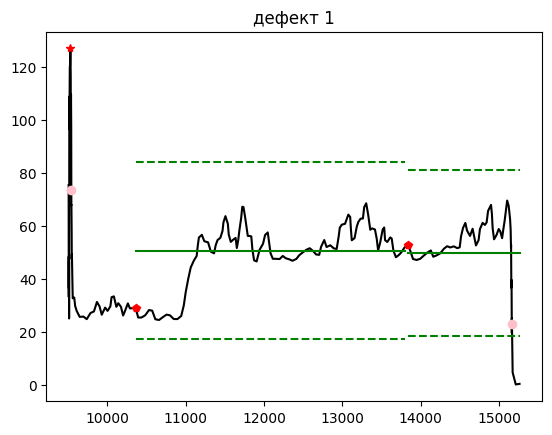

In [30]:
df = pd.read_csv("/home/marat/repo/jupyter_data/dataset/defect1.csv", sep ="|")
x, y = remove_duplicates(list(df.iloc[:, 0]), list(df.iloc[:, 1]))
#plt.plot(x, y)

x, y = smouthener(x, y, 5)
plt.plot(x, y, color="black")
plt.title("дефект 1")

end1 = len(x) // 4
end2 = end1 * 3


# расчитываем границы первоначальных областей поиска
border_left = (x[end1], y[end1])
border_right = (x[end2], y[end2])

plt.plot(border_left[0], border_left[1], "p", color="red")
plt.plot(border_right[0], border_right[1], "p", color="red")


# расчитываем максимумы в зоне 1
x_beg = x[:end1]
y_beg = y[:end1]
max_heigh_beg = max(y_beg)


# расчитываем характеристики распределения в зоне 2
x_mid = x[end1:end2]
y_mid = y[end1:end2]
b_l2, b_l_delta2 = calculate_base_line(y_mid, 3)
plot_base_line(x_mid, b_l2, b_l_delta2, len(x_mid))

# расчитываем характеристики распределения в зоне 3
x_end = x[end2:]
y_end = y[end2:]
b_l3, b_l_delta3 = calculate_base_line(y_end, 2)
plot_base_line(x_end, b_l3, b_l_delta3, len(x_end))


# находим пики в зоне 1
peaks_beg, _ = find_peaks(y_beg, height=0.9*max_heigh_beg)
for elm in peaks_beg:
    plt.plot(x_beg[elm], y_beg[elm], "*", color="red")

# расчитываем новые границы (по пикам и базовой линии зоны 2)
new_border_left = calculate_left_border(x, y, b_l2, b_l_delta2, peaks_beg[-1], end1, 5)
plt.plot(new_border_left[0], new_border_left[1], "o", color="pink")

# находим точку спада графика в зоне 3
rec_idx = calculate_recession(b_l3, b_l_delta3, y_end, 2)
rec_point = (x_end[rec_idx], y_end[rec_idx])
plt.plot(rec_point[0], rec_point[1], "o", color="pink")


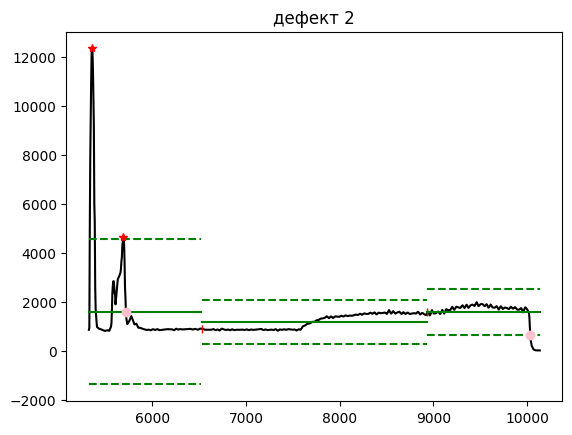

In [31]:
df = pd.read_csv("/home/marat/repo/jupyter_data/dataset/defect2.csv", sep ="|")
x, y = remove_duplicates(list(df.iloc[:, 0]), list(df.iloc[:, 1]))
#plt.plot(x, y)

x, y = smouthener(x, y, 5)
#plt.plot(x, y, color="black")

interp = interp1d(x, y, kind="linear")
x = np.linspace(x[0], x[-1], num=1000)
y = interp(x)

plt.plot(x, y, color="black")
plt.title("дефект 2")

end1 = len(x) // 4
end2 = end1 * 3

# расчитываем границы первоначальных областей поиска
border_left = (x[end1], y[end1])
border_right = (x[end2], y[end2])

plt.plot(border_left[0], border_left[1], "|", color="red")
plt.plot(border_right[0], border_right[1], "|", color="red")

# расчитываем максимумы в зоне 1
x_beg = x[:end1]
y_beg = y[:end1]
max_heigh_beg = max(y_beg)

# расчитываем характеристики распределения в зоне 2
x_mid = x[end1:end2]
y_mid = y[end1:end2]
b_l2, b_l_delta2 = calculate_base_line(y_mid, 3)
plot_base_line(x_mid, b_l2, b_l_delta2, len(x_mid))

# расчитываем характеристики распределения в зоне 3
x_end = x[end2:]
y_end = y[end2:]
b_l3, b_l_delta3 = calculate_base_line(y_end, 2)
plot_base_line(x_end, b_l3, b_l_delta3, len(x_end))

# расчитываем характеристики распределения в зоне 1 
# (для нахождения нескольких пиков - 
# т.к. мы и ожидали увидеть несколько пиков в данном случае открытия)
x_beg = x[:end1]
y_beg = y[:end1]
b_l1, b_l_delta1 = calculate_base_line(y_beg, 1.5)
plot_base_line(x_beg, b_l1, b_l_delta1, len(x_beg))

# находим пики в зоне 1
peaks_beg, _ = find_peaks(y_beg, height=b_l1+b_l_delta1)
for elm in peaks_beg:
    plt.plot(x_beg[elm], y_beg[elm], "*", color="red")


# расчитываем новую левую границу зоны 2 (по пикам и базовой линии зоны 2)
new_border_left = calculate_left_border(x, y, b_l2, b_l_delta2, peaks_beg[-1], end1, 5)
plt.plot(new_border_left[0], new_border_left[1], "o", color="pink")


# находим точку спада графика в зоне 3 (= правя граница зоны 2)
rec_idx = calculate_recession(b_l3, b_l_delta3, y_end, 2)
rec_point = (x_end[rec_idx], y_end[rec_idx])
plt.plot(rec_point[0], rec_point[1], "o", color="pink")